In [1]:
import random
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import LabelEncoder
from prophet import Prophet
import re
import copy

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

In [3]:
drive_path = "/content/drive/MyDrive/데이터 경진대회/제주 특산물 가격 예측"
train_data_path = drive_path + "/train.csv"
test_data_path = drive_path + "/test.csv"
sample_submission_path = drive_path + "/sample_submission.csv"

In [4]:
train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)

In [5]:
train_df["timestamp"] = pd.to_datetime(train_df["timestamp"])

In [6]:
category_list = train_df["ID"].str.replace(r'_\d{8}$', '', regex=True).unique()

In [7]:
def handle_data_to_prophet(df) :
  transformed_df = df[["ID", "timestamp", "price(원/kg)"]]
  transformed_df["ID"] = transformed_df["ID"].str.replace(r'_\d{8}$', '', regex=True)
  transformed_df = transformed_df.rename(columns={'timestamp': 'ds', 'price(원/kg)': 'y'})
  return transformed_df.copy()

In [8]:
prophet_train_data = handle_data_to_prophet(train_df)

In [9]:
prophet_train_data.head(5)

,ID,ds,y
0,TG_A_J,2019-01-01,0.0
1,TG_A_J,2019-01-02,0.0
2,TG_A_J,2019-01-03,1728.0
3,TG_A_J,2019-01-04,1408.0
4,TG_A_J,2019-01-05,1250.0


### Prophet 하이퍼 파라미터 탐색

In [10]:
search_data = prophet_train_data[prophet_train_data["ID"] == "TG_A_J"].drop(columns=["ID"]).sort_values("ds").copy()

In [11]:
train_size = int(len(search_data) * 0.8)
search_train_data = search_data[:train_size]
# 만약 0을 제외하고 사용하려면 아래 줄 주석을 해제하세요
# search_train_data = search_train_data[search_train_data["y"] > 0]
search_test_data = search_data[train_size:]

In [12]:
search_train_data

,ds,y
0,2019-01-01,0.0
1,2019-01-02,0.0
2,2019-01-03,1728.0
3,2019-01-04,1408.0
4,2019-01-05,1250.0
...,...,...
1213,2022-04-28,5508.0
1214,2022-04-29,5998.0
1215,2022-04-30,5415.0
1216,2022-05-01,0.0


In [13]:
param_grid = {
    'growth': ['linear'],
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 1, 5, 10],
    'seasonality_prior_scale': [0.01, 0.1, 1, 5, 10],
    'changepoint_range': [0.8, 0.85, 0.9, 0.95],
    'yearly_seasonality': [True, False],
    'weekly_seasonality': [True, False],
    'daily_seasonality': [True, False],
    'holidays_prior_scale': [0.1, 1, 5],
}

In [14]:
def prophet_grid_search(num_iterations, param_grid, train_data, y):
  results = []

  for _ in range(num_iterations) :
    random_params = {
        key : random.choice(value) for key, value in param_grid.items()
    }

    current_model = Prophet(**random_params)
    current_model.fit(train_data)

    y_size = len(y)

    future = current_model.make_future_dataframe(periods=y_size)
    forecast = current_model.predict(future)
    m_predict = forecast["yhat"].values[-y_size:]

    se = np.square(m_predict - y)
    rmse = np.sqrt(np.mean(se))

    results.append((random_params, rmse))
  return results


In [15]:
model_per_category = {}
for category in category_list:
  search_data = prophet_train_data[prophet_train_data["ID"] == category].drop(columns=["ID"]).sort_values("ds").copy()
  train_size = int(len(search_data) * 0.8)
  search_train_data = search_data[:train_size]
  # 만약 0을 제외하고 사용하려면 아래 줄 주석을 해제하세요
  # search_train_data = search_train_data[search_train_data["y"] > 0]
  search_test_data = search_data[train_size:]
  y = search_test_data["y"].values[:]
  results = prophet_grid_search(30, param_grid, search_train_data, y)
  sorted_results = sorted(results, key=lambda x : x[1])[:5]
  model_per_category[category] = sorted_results

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpseqb8u09/n6w8anpg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67052', 'data', 'file=/tmp/tmpseqb8u09/hgzaq0e2.json', 'init=/tmp/tmpseqb8u09/n6w8anpg.json', 'output', 'file=/tmp/tmpseqb8u09/prophet_modellz7s27w0/prophet_model-20231109135520.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:55:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:55:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpseqb8u09/_nz_6vhx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpseqb8u09/30qhrmzk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-package

In [16]:
test_result = model_per_category["TG_A_J"]

In [17]:
best_params, best_rmse = min(test_result, key=lambda x: x[1])

DEBUG:cmdstanpy:input tempfile: /tmp/tmpseqb8u09/wdgmtr63.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpseqb8u09/8113v2vm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67200', 'data', 'file=/tmp/tmpseqb8u09/wdgmtr63.json', 'init=/tmp/tmpseqb8u09/8113v2vm.json', 'output', 'file=/tmp/tmpseqb8u09/prophet_modelcg3kyq7i/prophet_model-20231109140632.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:06:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:06:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


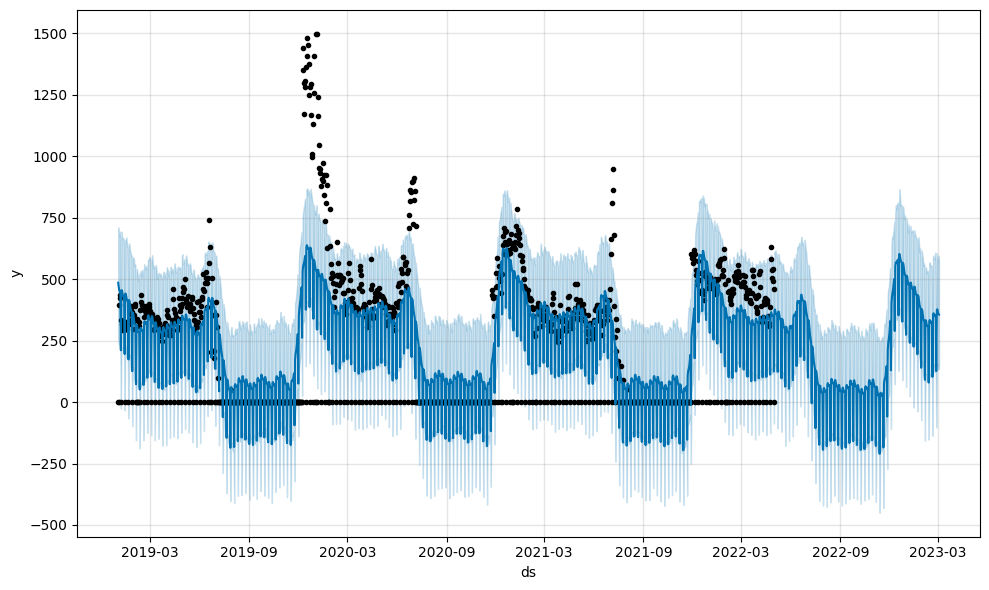

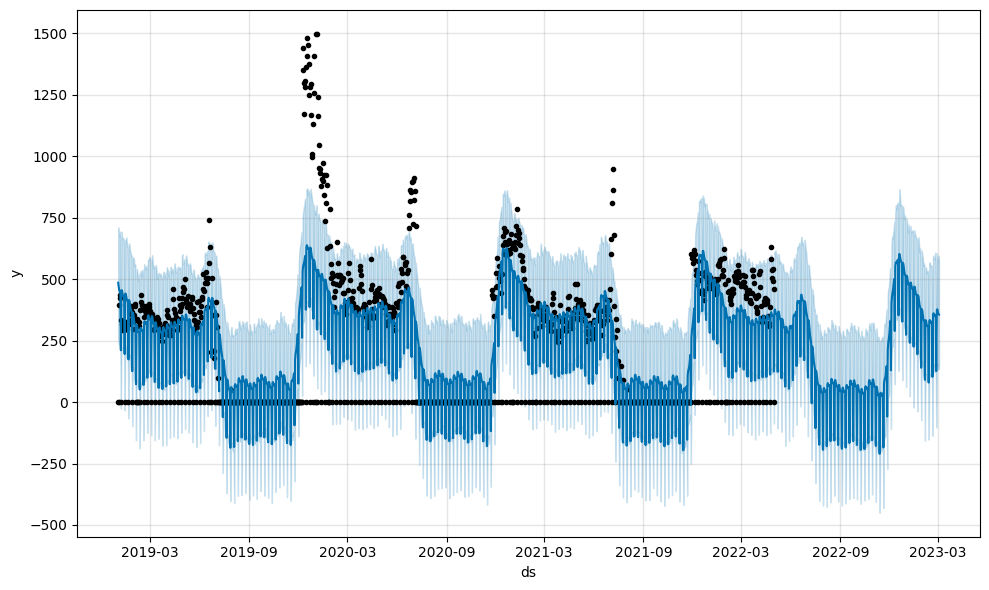

In [18]:
test_model = Prophet(**best_params)
test_model.fit(search_train_data)
future = test_model.make_future_dataframe(periods=305)
forecast = test_model.predict(future)
test_model.plot(forecast)

In [19]:
prophet_map = {}

In [20]:
for category in category_list :
  category_prophet_result = model_per_category[category]
  best_params, best_rmse = min(category_prophet_result, key=lambda x: x[1])
  main_model = Prophet(
      **best_params
  )
  current_category_train_x = prophet_train_data[prophet_train_data["ID"] == category].drop(columns=["ID"]).sort_values("ds")
  prophet_map[category] = main_model.fit(current_category_train_x)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpseqb8u09/lko9utnv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpseqb8u09/z64a8gxs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29418', 'data', 'file=/tmp/tmpseqb8u09/lko9utnv.json', 'init=/tmp/tmpseqb8u09/z64a8gxs.json', 'output', 'file=/tmp/tmpseqb8u09/prophet_modelq15t1qqx/prophet_model-20231109140643.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:06:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:06:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpseqb8u09/x1telc_9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpseqb8u09/xp0hu9wh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [21]:
test_df["price(원/kg)"] = 0

In [22]:
prophet_test_data = handle_data_to_prophet(test_df)

In [23]:
result_map = {}
for category in category_list :
  current_category_test_x = prophet_test_data[prophet_test_data["ID"] == category].drop(columns=["ID"])
  model = prophet_map[category]
  y = model.predict(current_category_test_x)
  result_map[category] = y["yhat"].values.tolist()

In [24]:
copy_result_map = copy.deepcopy(result_map)

In [25]:
def assign_result(row) :
  category = re.sub(r'_\d{8}$', '', row["ID"])
  result = copy_result_map[category]
  return result.pop(0)

In [26]:
submission = pd.read_csv(sample_submission_path)

In [27]:
submission.head()

,ID,answer
0,TG_A_J_20230304,0
1,TG_A_J_20230305,0
2,TG_A_J_20230306,0
3,TG_A_J_20230307,0
4,TG_A_J_20230308,0


In [28]:
submission["answer"] = 0

In [29]:
submission["answer"] = submission.apply(assign_result, axis=1)

In [30]:
submission.tail()

,ID,answer
1087,RD_F_J_20230327,366.497787
1088,RD_F_J_20230328,373.845092
1089,RD_F_J_20230329,363.888414
1090,RD_F_J_20230330,356.250767
1091,RD_F_J_20230331,350.316457


In [35]:
submission.loc[submission["answer"] < 0, "answer"] = 0

In [36]:
submission[submission["answer"] < 0]

,ID,answer


In [37]:
submission.to_csv(drive_path + "/submission_231109_1.csv", index=False)

In [38]:
len(category_list)

39